In [2]:
# Hyperparameters
data_folder = "prototype" # Folder name; need to be in the same directory as jupyter notebook directory

# Used to combine + padding and truncating data; see info regarding lengths of data to avoid over truncation
max_length = 25
# SHORTER max_len seems to work better
# MIN value: should be larger than longest shortened_sequences

duplicate = 20 # Multiply by n number of times (for better randomisation)
top_ddx = 10
top_prob = 5


embedding_dim = 64
trunc_type = 'post'
padding_type = 'post'
training_portion = 0.99 #training validation split
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", 
              "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", 
              "can", "could", 
              "did", "do", "does", "doing", "down", "during", 
              "each", 
              "few", "for", "from", "further", 
              "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", 
              "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
              "let's", 
              "may", "me", "more", "most", "my", "myself", 
              "nor", 
              "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", 
              "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", 
              "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", 
              "under", "until", "up", 
              "very", "was", 
              "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", 
              "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves",
            
              # Noisy words other than stopwords
              "affected", "also",
              "eg"
            
            ]
seed = 200 # Value should be greater than "duplication" hyperparameter (In grouping function, "counter" is used as the seed for random.sample)

In [3]:
import glob
import os
import matplotlib.pyplot as plt
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(tf.__version__)

2.2.0-dev20200405


## 1. Info

In [4]:
# Info regarding big folder
conditions = os.listdir(os.path.join(os.getcwd(), data_folder)) 
print("Total conditions:", len(conditions), "\n")
print("- List of all conditions:", "\n", conditions)

Total conditions: 10 

- List of all conditions: 
 ['acromegaly', 'addisons_disease', 'aplastic_anaemia', 'asthma', 'gout', 'graves_disease', 'nephrolithiasis', 'systemic_sclerosis', 'ulcerative_colitis', 'urticaria']


## 2. Extracting files and generates data

### 2.1 Load, split \n and remove stopwords function

In [5]:
# Combines all .txt files in a folder into a list of list (with each .txt file in a small list)
def raw_text(folder_name): # takes in "condition" subfolder
    path = os.getcwd() + "\\" + folder_name + "\\" + "*.txt"
    file_list = glob.glob(path)
    
    corpus = []
    
    for file_path in file_list:
        with open(file_path, encoding="utf8") as f_input:
            corpus.append(f_input.read())
    
    return corpus

# Split \n (i.e. within 1 txt file), combines lists in list (sequences within one txt file are in one seperate list) and removes empty lines.
def split_and_combine(corpus):
    split_new_line = []
    for i in corpus:
        split = i.split("\n")
        split_new_line.append(split)
    split_combined = sum(split_new_line,[])
    
    remove_empty = []
    for i in split_combined:
        if len(i) > 0:
            remove_empty.append(i)
    
    return remove_empty

# Lower, remove punctutation (except "." for cleaning) and remove stopwords
def cleaning(sequence_list):

    clean_list = []

    for sequence in sequence_list:
        # Lower
        sequence = sequence.lower()

        # Removes punctutation, except "."
        no_punctutation = ""
        for i in sequence:
            if i not in '!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n':
                no_punctutation += i
        sequence = no_punctutation
        
        # Removes stopwords
        sequence_no_stopwords = [] # List, will be converted back to string
        split = sequence.split(" ")
        for word in split:
            if word not in stopwords:
                sequence_no_stopwords.append(word)
        list_to_string = " ".join(sequence_no_stopwords)
        
        clean_list.append(list_to_string)
    
    return clean_list

### 2.2 (Info) Finds spread of lengths of data function

In [6]:
# (Info) Finds spread of lengths of data
def sequence_spread(list_of_strings):
    sequences_info_dict = {}
    
    max_seq = 0
    total_words = 0
    for sequence in list_of_strings:
        
        split = sequence.split()
        counter = 0
        for word in split:
            counter += 1
            total_words += 1
        
        if counter > max_seq:
            max_seq = counter
        
        if counter not in sequences_info_dict:
            sequences_info_dict[counter] = 1
        else:
            sequences_info_dict[counter] += 1
    
    sorted_dict = {k: v for k, v in sorted(sequences_info_dict.items(), key=lambda item: item[0])}
            
    return sorted_dict, max_seq, total_words

### 2.3 Group sequences into longer sequences function

In [7]:
# Group sequences with length no longer than max_length; sequences are randomized
# Also gets info (no. of sequences, spread, max, total words) of each condition before grouping
def grouping(clean_data, condition):
    
    shortened_sequences = []
    # Split long sequences by "."
    for sequence in clean_data:
        split = sequence.split(".")
        for string in split:
            # Removes empty "" and " " generated from splitting sequences ending with "." or ". "
            if len(string) > 0 and string != " ":
                shortened_sequences.append(string)
    
    shortened_sequences_spread, shortened_sequences_max , shortened_sequences_words_total = sequence_spread(shortened_sequences)
    
    
    # Duplication of data for better randomisation
    duplicated_data = random.Random(seed).sample(shortened_sequences, len(shortened_sequences))
    counter = 1
    while True:
        if counter == duplicate: # Hyperparameter
            break 
        duplicated_data += random.Random(counter).sample(shortened_sequences, len(shortened_sequences)) # Random(counter) for reproducibility
        counter += 1
    
    
    # GROUPING sequences together without exceeding max_length length
    sequences_grouped = []
    temporary_grouping = ""
    temporary_word_count = 0

    for sequence in duplicated_data:

        split = sequence.split()
        counter = 0
        for word in split:
            counter += 1
        
        if (temporary_word_count + counter) < max_length:
            temporary_grouping = temporary_grouping + " " + sequence
            temporary_word_count += counter
        else:
            sequences_grouped.append(temporary_grouping)
            temporary_grouping = sequence
            temporary_word_count = counter
    
    print("Condition: {} (before grouping)".format(condition), "\n")
    print("Total sequences:", len(shortened_sequences))
    print("Length of longest sequence:", shortened_sequences_max)
    print("Spread of sequence:", "\n", shortened_sequences_spread)
    print("Total words:", shortened_sequences_words_total)
    print("===============================================")
    
    return sequences_grouped

### 2.4 Generates labels function

In [8]:
# Generates labels for conditions
def gen_labels(data_list, condition):
    
    labels = []
    counter = 0
    
    while True:
        labels.append(condition)
        counter += 1
        if counter == len(data_list):
            break
    
    return labels

### 2.5 Generates all data and labels

In [9]:
# Generates complete set of data with corresponding labels
def all_data_and_labels(big_folder):
    
    subfolder_list = os.listdir(os.path.join(os.getcwd(), big_folder))
    
    all_data = []
    all_labels = []
    
    counter = 0 # Represents labels using int
    for i in subfolder_list:
            
            path = big_folder + "\\" + i
            data = cleaning(split_and_combine(raw_text(path)))
            grouped_data = grouping(data, i)
                
            labels = gen_labels(grouped_data, counter)
            
            all_data.append(grouped_data)
            all_labels.append(labels)
            counter += 1
            
    all_data = sum(all_data,[])
    spread_of_all_data, max_sequence, total_words_of_all_data = sequence_spread(all_data)
    
    all_labels = sum(all_labels,[])
    
    print("Total data after split and grouping:", len(all_data))
    print("Total labels after split and grouping:", len(all_labels), "\n")
    
    print("Removed stopwords:", len(stopwords), "\n")
    
    print("Length of longest sequence:", max_sequence)
    print("Spread of data:", "\n", spread_of_all_data)
    print("Total words:", total_words_of_all_data)

    return all_data, all_labels

complete_data, complete_labels = all_data_and_labels(data_folder) 

Condition: acromegaly (before grouping) 

Total sequences: 47
Length of longest sequence: 21
Spread of sequence: 
 {1: 8, 2: 4, 3: 8, 4: 6, 5: 8, 6: 4, 8: 1, 9: 1, 10: 1, 11: 2, 14: 2, 16: 1, 21: 1}
Total words: 242
Condition: addisons_disease (before grouping) 

Total sequences: 32
Length of longest sequence: 10
Spread of sequence: 
 {1: 2, 2: 4, 3: 7, 4: 7, 5: 4, 6: 2, 7: 4, 10: 2}
Total words: 139
Condition: aplastic_anaemia (before grouping) 

Total sequences: 73
Length of longest sequence: 14
Spread of sequence: 
 {1: 18, 2: 25, 3: 15, 4: 6, 6: 2, 7: 3, 8: 2, 11: 1, 14: 1}
Total words: 211
Condition: asthma (before grouping) 

Total sequences: 48
Length of longest sequence: 17
Spread of sequence: 
 {1: 5, 2: 6, 3: 5, 4: 6, 5: 4, 6: 3, 7: 2, 8: 5, 9: 5, 10: 1, 12: 1, 13: 3, 14: 1, 17: 1}
Total words: 285
Condition: gout (before grouping) 

Total sequences: 86
Length of longest sequence: 20
Spread of sequence: 
 {1: 13, 2: 17, 3: 10, 4: 2, 5: 2, 6: 6, 7: 9, 8: 5, 9: 5, 10: 3, 11: 4,

In [10]:
print("- Raw data:", "\n", complete_data[:5], "\n")
print("- Labels:", "\n", complete_labels[:20])

- Raw data: 
 [' enlargement lips nose tongue enlargement feet increased heel pad thickness prognathism growth lower jaw igt 25type 2 diabetes 10 prognathism noticeably large pores', 'skull growth – prominent supraorbital ridges large frontal sinuses excessive eccrine apocrine sweating colon cancer 2–3 × ↑ hyperphosphatemia hypercalcuria hypertriglyceridemia possible', 'increased incidence obstructive sleep apnea arthritis increase ring andor shoe size breast tissue becoming atrophic galactorrhea', 'doughyfeeling skin face extremities one earliest signs acromegaly swelling soles palms myopathy wide spacing teeth prognathism', 'acanthosis nigricans small percentage patients results excessive stimulation keratinocytes fibroblasts skin headache increased incidence glucose intolerance frank diabetes mellitus hypertension cardiovascular disease  6'] 

- Labels: 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## 3. Data shuffling and tokenize

In [11]:
# Randomize data and labels synchronously (before training validation split)
zip_list = list(zip(complete_data, complete_labels))
random.Random(seed).shuffle(zip_list)
data, labels = zip(*zip_list)
data, labels = list(data), list(labels)

print("- Randomized data:", "\n", data[:5], "\n")
print("- Randomized labels:", "\n", labels[:5], "\n")

# Splitting into training and validation sets
train_size = int(len(data) * training_portion)

# Train/ validation split (NOTE: labels are split separately before one-hot encoding)
train_data = data[0: train_size]
validation_data = data[train_size:]

print('Training / Validation split:', training_portion)
print("Training data:", len(train_data))
print("Validation data:", len(validation_data))

- Randomized data: 
 ['ophthalmologic  tearing gritty sensation eye photophobia eye pain protruding eye diplopia visual loss ophthalmopathy dermopathy eddening thickening skin shins tops feet', 'tophi nodular masses along helix ear fingers toes prepatellar bursa along olecranon rarely creamy discharge xanthine oxidase inhibitors allopurinol febuxostat', 'increased sweating noticeably large pores oily skin acne not common bitemporal hemianopsia  6 wide spacing teeth prognathism prognathism growth lower jaw', 'nausea diarrhea vomiting gastrointestinal symptoms dehydration hypotension orthostatic hypotension postural hypotension extreme fatigue female patients show absence axillary pubic hair decreased body hair', 'exercise painful swelling angioedema lips eyelids inside throat raised wellcircumscribed areas erythema redness edema swelling involving dermis epidermis pruritic itchy'] 

- Randomized labels: 
 [5, 4, 0, 1, 9] 

Training / Validation split: 0.99
Training data: 2643
Validation

In [12]:
# Tokenizes all words in data by frequency
# Also filters punctuation, lowerscase, splits word
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(data) # Updates internal vocab dictionary, sorted by frequency

word_index = tokenizer.word_index
max_key = max(word_index, key=word_index.get)
vocab_size = word_index[max_key]

print(dict(list(word_index.items())))
print(vocab_size)

{'pain': 1, 'skin': 2, 'joint': 3, 'loss': 4, 'increased': 5, 'abdominal': 6, 'severe': 7, 'blood': 8, 'fever': 9, 'usually': 10, 'diarrhea': 11, 'areas': 12, 'weight': 13, 'exposure': 14, 'joints': 15, 'cold': 16, 'infections': 17, 'lower': 18, 'red': 19, 'gout': 20, 'chest': 21, 'fingers': 22, 'nausea': 23, 'swelling': 24, 'weakness': 25, 'wheezing': 26, 'acid': 27, 'fatigue': 28, 'bleeding': 29, 'hypertension': 30, 'vomiting': 31, 'exercise': 32, 'appetite': 33, 'pressure': 34, 'muscle': 35, 'shortness': 36, 'breath': 37, 'uric': 38, 'increase': 39, 'enlargement': 40, 'infection': 41, 'bowel': 42, 'small': 43, 'heat': 44, 'eyes': 45, 'stress': 46, 'hands': 47, 'nose': 48, 'body': 49, 'used': 50, 'disease': 51, 'thyroid': 52, 'arthritis': 53, 'heart': 54, 'certain': 55, 'drugs': 56, 'women': 57, 'menstrual': 58, 'levels': 59, 'fine': 60, 'foods': 61, 'diabetes': 62, 'medications': 63, 'attacks': 64, 'hair': 65, 'respiratory': 66, 'renal': 67, 'eye': 68, 'feet': 69, 'not': 70, 'sympto

In [13]:
# Converts words to corresponding tokens
train_sequences = tokenizer.texts_to_sequences(train_data) # Converts text in texts to a sequence of integers
validation_sequences = tokenizer.texts_to_sequences(validation_data)

print(train_sequences[:5])
print(validation_sequences[:5])

[[515, 516, 255, 147, 68, 517, 68, 1, 518, 68, 519, 148, 4, 256, 257, 520, 149, 2, 258, 259, 69], [252, 521, 522, 260, 523, 261, 22, 91, 524, 525, 260, 526, 262, 527, 150, 528, 529, 530, 263, 531], [5, 133, 532, 92, 533, 534, 2, 535, 70, 239, 536, 537, 538, 264, 539, 540, 151, 151, 265, 18, 541], [23, 11, 31, 266, 71, 84, 146, 1342, 146, 1343, 146, 267, 28, 490, 85, 1344, 491, 1345, 1346, 65, 90, 49, 65], [32, 152, 24, 268, 72, 134, 542, 240, 153, 543, 12, 154, 269, 93, 24, 544, 545, 546, 270, 155]]
[[61, 391, 811, 812, 813, 814, 815, 816, 817, 818, 819, 104, 387, 268, 72, 408, 841, 1025, 744, 745], [3, 24, 1145, 154, 73, 753, 207, 55, 126, 159, 39, 78, 20, 250, 64, 1243, 1244, 1245, 416, 223], [344, 345, 140, 346, 347, 380, 100, 909, 910, 322, 911, 912, 913, 50, 100, 303, 914, 915, 916, 220, 431, 917, 3, 73], [1074, 245, 20, 231, 459, 51, 189, 849, 56, 850, 851, 852, 853, 854], [606, 19, 292, 97, 1, 984, 985, 986, 437, 1251, 1252, 1253, 73, 1, 196, 1254, 6, 429, 1255, 1256, 1257]]


In [14]:
# Pads sequences to max_length
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type, dtype='int64')
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(train_padded.shape)
print(type(train_padded))
print(validation_padded.shape)
print(type(validation_padded))

(2643, 25)
<class 'numpy.ndarray'>
(27, 25)
<class 'numpy.ndarray'>


In [15]:
print(set(labels))
print("Number of classes:", len(set(labels)))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Number of classes: 10


In [16]:
one_hot_labels = to_categorical(np.array(labels))

train_labels = one_hot_labels[0: train_size]
validation_labels = one_hot_labels[train_size:]

print(train_labels)
print(train_labels.shape)
print(type(train_labels))

print(validation_labels)
print(validation_labels.shape)
print(type(validation_labels))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(2643, 10)
<class 'numpy.ndarray'>
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 

## 4. LSTM Model

In [17]:
# Embedding layer for word embedding with embedding dimensions of 64
# Bidirectional LSTM

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(len(conditions), activation='softmax')
])
model.summary()


"""
NOTE: return_sequence is not being used
- return_sequence=True returns many to many outputs, but all the outputs (i.e. at each "timestep") will be used to calculate loss
- return_requence=False returns many to one output, in which all hidden outputs are "eaten" and cannot be used to tract probability changes

"""

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          89152     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


'\nNOTE: return_sequence is not being used\n- return_sequence=True returns many to many outputs, but all the outputs (i.e. at each "timestep") will be used to calculate loss\n- return_requence=False returns many to one output, in which all hidden outputs are "eaten" and cannot be used to tract probability changes\n\n'

## 5. Training

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 50
history = model.fit(train_padded, train_labels, epochs=num_epochs, verbose=2, validation_data=(validation_padded, validation_labels))

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the

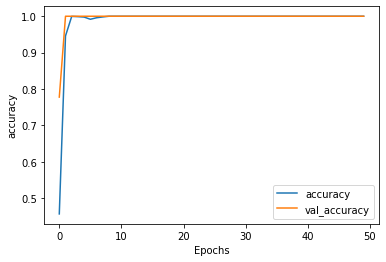

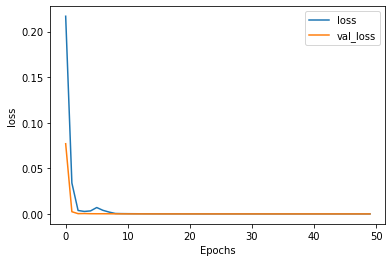

In [19]:
# NOTE: validation curve is not too useful due to limited data + high train/val split
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## 6. Testing (with glassbox for top 1 ddx)

In [20]:
def test(string):
    seq = tokenizer.texts_to_sequences(string) # Tokenizer automatically removes punctuations and OOV words
    padded = pad_sequences(seq, maxlen=max_length)
    output = model.predict(padded)
    prediction = conditions[np.argmax(output)]
    
    index = np.arange(len(conditions))
    # Arrange output and corresponding index into descending order
    output, index = zip(*sorted(zip(output[0], index), reverse=True))
    
    
    # Calculates change in output probabilities for every timestep
    last_prob = 0
    prob_difference_list = []
    for timestep in range(1, max_length): # NOTE: timestep is used for range; index = timestep - 1
        
        t_seq = seq[0][:timestep]
        # Reformats [] to [[]] before padding
        reformat = []
        reformat.append(t_seq)
        
        t_padded = pad_sequences(reformat, maxlen=max_length)
        t_output = model.predict(t_padded)

        prob_difference = t_output[0][index[0]] - last_prob
        prob_difference_list.append(prob_difference)
        last_prob = t_output[0][index[0]]

    prob_index = np.arange(max_length)
    prob_difference_list, prob_index = zip(*sorted(zip(prob_difference_list, prob_index), reverse=True))
    
    # Converts tokens back to text
    token_to_text = {v: k for k, v in tokenizer.word_index.items()}
    
    # Gets indices within a sequence with highest changes in prob, gets tokens from padded_sequence, converts tokens to text
    culprits = []
    for i in prob_index:
        t_token = padded[0][i]
 
        if t_token != 0:
            culprits.append(token_to_text[t_token])
    culprits = culprits[:top_prob]
    
    print("Input string:", string)
    print("Model prediction:", prediction)
    print("Culprits:", culprits)
    print("Analysis of top {} Ddx:".format(top_ddx))

    for out, ind in zip(output[:top_ddx], index[:top_ddx]):
        print("- {}: {}".format(conditions[ind], out))
        
    print("========================================")
    
    return prediction

In [21]:
print("Testing:", "\n")
# Testing data ~ 20 words
correct = 0
total = 0

print("Condition: ACROMEGALY")
print()
acromegaly = test(["large nose and large tongue with bitermporal hemianopia; large hands and large feet; Coarse, oily, thickened skin; Small outgrowths of skin tissue (skin tags)"])
total += 1
if acromegaly == "acromegaly":
    correct += 1

print("Condition: ADDISONS")
print()
addisons_disease = test(["unusual fatigue, weakness, frequent diarrhea, a craving of salty foods; generalized muscle weakness, low blood sugar, hyperpigmentation of multiple areas of skin; Low blood pressure;  lightheadedness upon standing, irritability, depression, and diarrhea."])
total += 1
if addisons_disease == "addisons_disease":
    correct += 1

print("Condition: APLASTIC")
print()
aplastic_anaemia = test(["tired and out of breath after only a little exercise, rapid heartbeat, Headache; bruise and bleed easily, Bleeding that won’t stop, small red dots on the skin that indicates bleeding under the skin; repeated fevers and infections"])
total += 1
if aplastic_anaemia == "aplastic_anaemia":
    correct += 1

print("Condition: ASTHMA")
print()
asthma = test(["wheezing (a whistling sound when breathing), breathlessness, tight chest; recurrent; worse at night and early in the morning; exposure to pollen or animal fur; Coughing, especially at night; Chest tightness, pain, or pressure"])
total += 1
if asthma == "asthma":
    correct += 1

print("Condition: GOUT")
print()
gout = test(["Sudden severe pain in joint over the big toe;red, hot, swollen skin over the affected joint; metatarsal-phalangeal joint; consumption of alcohol and meat"])
total += 1
if gout == "gout":
    correct += 1
    
print("Condition: GRAVES")
print()
graves_disease = test(["fast and irregular heartbeat; frequent bowel movements or diarrhea; goiter; heat intolerance; nervousness or irritability; tiredness or muscle weakness; trembling hands; weight loss"])
total += 1
if graves_disease == "graves_disease":
    correct += 1
    
print("Condition: RENAL STONES")
print()
nephrolithiasis = test(["Pain while urinating; Blood in your urine; Sharp pain in your back or lower abdomen (loin); Nausea and vomiting; sharp, cramping pain in the back and side"])
total += 1
if nephrolithiasis == "nephrolithiasis":
    correct += 1
    
print("Condition: Systemic scleroris")
print()
systemic_sclerosis = test(["hardening and scarring. The skin may appear tight, reddish, or scaly; impairment in lung function; shortness of breath; reflux esophagitis"])
total += 1
if systemic_sclerosis == "systemic_sclerosis":
    correct += 1
    
print("Condition: Ulcerative colitis")
print()
ulcerative_colitis = test(["recurring diarrhoea, which may contain blood, mucus or pus; tiredness (fatigue), loss of appetite and weight loss; anemia (pallor) painful arthritic knees"])
total += 1
if ulcerative_colitis == "ulcerative_colitis":
    correct += 1
    
print("Condition: Urticaria")
print()
urticaria = test(["swollen, pale red bumps or plaques (wheals) on the skin;  itching, but may also burn or sting; face, lips, tongue, throat, or ears"])
total += 1
if urticaria == "urticaria":
    correct += 1
    
print("Accuracy = {}/{}".format(correct, total))

Testing: 

Condition: ACROMEGALY

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input string: ['large nose and large tongue with bitermporal hemianopia; large hands and large feet; Coarse, oily, thickened skin; Small outgrowths of skin tissue (skin tags)']
Model prediction: acromegaly
Culprits: ['large', 'large', 'large', 'large', 'skin']
Analysis of top 10 Ddx:
- acromegaly: 0.9579713344573975
- urticaria: 0.026124320924282074
- 

## 7. Glassbox for all top_ddx

In [22]:
def top_ddx_test(string):
    seq = tokenizer.texts_to_sequences(string) # Tokenizer automatically removes punctuations and OOV words
    padded = pad_sequences(seq, maxlen=max_length)
    output = model.predict(padded)
    prediction = conditions[np.argmax(output)]
    
    index = np.arange(len(conditions)) # Used to retrieve class labels
    # Arrange output and corresponding index into descending order
    output, index = zip(*sorted(zip(output[0], index), reverse=True))

    print(string)
    print("Model prediction:", prediction)
    
    
    print("Analysis of top {} Ddx:".format(top_ddx), "\n")
    for out, ind in zip(output[:top_ddx], index[:top_ddx]):
        print("- {}: {}".format(conditions[ind], out))
        
        # Calculates change in output probabilities for every timestep
        last_prob = 0
        prob_difference_list = []
        for timestep in range(1, max_length): # NOTE: timestep is used for range; index = timestep - 1

            t_seq = seq[0][:timestep]
            # Reformats [] to [[]] before padding
            reformat = []
            reformat.append(t_seq)

            t_padded = pad_sequences(reformat, maxlen=max_length)
            t_output = model.predict(t_padded)

            prob_difference = t_output[0][index[ind]] - last_prob
            prob_difference_list.append(prob_difference)
            last_prob = t_output[0][index[ind]]

        prob_index = np.arange(max_length)
        prob_difference_list, prob_index = zip(*sorted(zip(prob_difference_list, prob_index), reverse=True))

        # Converts tokens back to text
        token_to_text = {v: k for k, v in tokenizer.word_index.items()}

        # Gets indices within a sequence with highest changes in prob, gets tokens from padded_sequence, converts tokens to text
        culprits = []
        for i in prob_index:
            t_token = padded[0][i]

            if t_token != 0:
                culprits.append(token_to_text[t_token])
        culprits = culprits[:top_prob]
        print("- culprits:", culprits, "\n")
        
    print("===================================================")
    
    return prediction

In [23]:
print("Urticaria")
urticaria = top_ddx_test(["swollen, pale red bumps or plaques (wheals) on the skin;  itching, but may also burn or sting; face, lips, tongue, throat, or ears"])

Urticaria
['swollen, pale red bumps or plaques (wheals) on the skin;  itching, but may also burn or sting; face, lips, tongue, throat, or ears']
Model prediction: urticaria
Analysis of top 10 Ddx: 

- urticaria: 0.9437355995178223
- culprits: ['throat', 'tongue', 'lips', 'face', 'itching'] 

- asthma: 0.04762108623981476
- culprits: ['throat', 'tongue', 'lips', 'face', 'itching'] 

- gout: 0.006073903292417526
- culprits: ['throat', 'tongue', 'lips', 'face', 'itching'] 

- graves_disease: 0.0011894149938598275
- culprits: ['throat', 'tongue', 'lips', 'face', 'itching'] 

- aplastic_anaemia: 0.0008020443492569029
- culprits: ['throat', 'tongue', 'lips', 'face', 'itching'] 

- systemic_sclerosis: 0.0005085798329673707
- culprits: ['throat', 'tongue', 'lips', 'face', 'itching'] 

- nephrolithiasis: 3.540398756740615e-05
- culprits: ['throat', 'tongue', 'lips', 'face', 'itching'] 

- acromegaly: 3.3047479519154876e-05
- culprits: ['throat', 'tongue', 'lips', 'face', 'itching'] 

- addisons

## 8. Diagnostics

In [31]:
def string_len(string):
    counter = 0
    split = string[0].split()
    for word in split:
        counter += 1
    return counter
    
def d_test(string):
    length = string_len(string)
    seq = tokenizer.texts_to_sequences(string) # Tokenizer automatically removes punctuations and OOV words
    padded = pad_sequences(seq, maxlen=max_length)
    output = model.predict(padded)
    print("Output shape", output.shape)
    print("Output type", type(output))
    print("Raw output", output)
    prediction = conditions[np.argmax(output)]
    
    index = np.arange(len(conditions))
    # Arrange output and corresponding index into descending order
    output, index = zip(*sorted(zip(output[0], index), reverse=True))
    
    
    # Calculates change in output probabilities for every timestep
    last_prob = 0
    prob_difference_list = []
    for timestep in range(1, max_length): # NOTE: timestep is used for range; index = timestep - 1
        
        t_seq = seq[0][:timestep]
        # Reformats [] to [[]] before padding
        reformat = []
        reformat.append(t_seq)
        
        t_padded = pad_sequences(reformat, maxlen=max_length)
        t_output = model.predict(t_padded)

        prob_difference = t_output[0][index[0]] - last_prob
        prob_difference_list.append(prob_difference)
        last_prob = t_output[0][index[0]]

    prob_index = np.arange(max_length)
    prob_difference_list, prob_index = zip(*sorted(zip(prob_difference_list, prob_index), reverse=True))
    
    # Converts tokens back to text
    token_to_text = {v: k for k, v in tokenizer.word_index.items()}
    
    # Gets indices within a sequence with highest changes in prob, gets tokens from padded_sequence, converts tokens to text
    culprits = []
    for i in prob_index:
        t_token = padded[0][i]
        if t_token != 0:
            culprits.append(token_to_text[t_token])
    culprits = culprits[:top_prob]
    
    print("Model prediction:", prediction)
    
    print(string)
    print("String length:", length)
    print(seq)
    print("Length of sequence:", len(seq[0]))
    print(padded)
    print(prediction)
    
    print("Culprits:", culprits)
    print("Analysis of top {} Ddx:".format(top_ddx))

    for out, ind in zip(output[:top_ddx], index[:top_ddx]):
        print("- {}: {}".format(conditions[ind], out))
        
    print("========================================")
    
    return prediction

In [32]:
print("Diagnostics:", "\n")
# Testing data ~ 20 words
correct = 0
total = 0

print("ACROMEGALY")
acromegaly = d_test(["large nose and large tongue with bitermporal hemianopia; large hands and large feet; Coarse, oily, thickened skin; Small outgrowths of skin tissue (skin tags)"])
total += 1
if acromegaly == "acromegaly":
    correct += 1

print("ADDISONS")
addisons_disease = d_test(["unusual fatigue, weakness, frequent diarrhea, a craving of salty foods; generalized muscle weakness, low blood sugar, hyperpigmentation of multiple areas of skin; Low blood pressure;  lightheadedness upon standing, irritability, depression, and diarrhea."])
total += 1
if addisons_disease == "addisons_disease":
    correct += 1

print("APLASTIC")
aplastic_anaemia = d_test(["tired and out of breath after only a little exercise, rapid heartbeat, Headache; bruise and bleed easily, Bleeding that won’t stop, small red dots on the skin that indicates bleeding under the skin; repeated fevers and infections"])
total += 1
if aplastic_anaemia == "aplastic_anaemia":
    correct += 1

print("ASTHMA")
asthma = d_test(["wheezing (a whistling sound when breathing), breathlessness, tight chest; recurrent; worse at night and early in the morning; exposure to pollen or animal fur; Coughing, especially at night; Chest tightness, pain, or pressure"])
total += 1
if asthma == "asthma":
    correct += 1

print("GOUT")
gout = d_test(["Sudden severe pain in joint over the big toe;red, hot, swollen skin over the affected joint; metatarsal-phalangeal joint; consumption of alcohol and meat"])
total += 1
if gout == "gout":
    correct += 1
    
print("GRAVES")
graves_disease = d_test(["fast and irregular heartbeat; frequent bowel movements or diarrhea; goiter; heat intolerance; nervousness or irritability; tiredness or muscle weakness; trembling hands; weight loss"])
total += 1
if graves_disease == "graves_disease":
    correct += 1
    
print("RENAL STONES")
nephrolithiasis = d_test(["Pain while urinating; Blood in your urine; Sharp pain in your back or lower abdomen (loin); Nausea and vomiting; sharp, cramping pain in the back and side"])
total += 1
if nephrolithiasis == "nephrolithiasis":
    correct += 1
    
print("Systemic scleroris")
systemic_sclerosis = d_test(["hardening and scarring. The skin may appear tight, reddish, or scaly; impairment in lung function; shortness of breath; reflux esophagitis"])
total += 1
if systemic_sclerosis == "systemic_sclerosis":
    correct += 1
    
print("Ulcerative colitis")
ulcerative_colitis = d_test(["recurring diarrhoea, which may contain blood, mucus or pus; tiredness (fatigue), loss of appetite and weight loss; anemia (pallor) painful arthritic knees"])
total += 1
if ulcerative_colitis == "ulcerative_colitis":
    correct += 1
    
print("Urticaria")
urticaria = d_test(["swollen, pale red bumps or plaques (wheals) on the skin;  itching, but may also burn or sting; face, lips, tongue, throat, or ears"])
total += 1
if urticaria == "urticaria":
    correct += 1
    
print("Accuracy = {}/{}".format(correct, total))

Diagnostics: 

ACROMEGALY
Output shape (1, 10)
Output type <class 'numpy.ndarray'>
Raw output [[9.5797133e-01 5.1987814e-09 7.4014072e-03 6.5207978e-08 2.1854021e-08
  1.3956107e-09 6.3432794e-11 8.5028885e-03 2.5172639e-08 2.6124321e-02]]
Model prediction: acromegaly
['large nose and large tongue with bitermporal hemianopia; large hands and large feet; Coarse, oily, thickened skin; Small outgrowths of skin tissue (skin tags)']
String length: 24
[[92, 48, 92, 408, 92, 47, 92, 69, 534, 130, 2, 43, 2, 248, 2, 389]]
Length of sequence: 16
[[  0   0   0   0   0   0   0   0   0  92  48  92 408  92  47  92  69 534
  130   2  43   2 248   2 389]]
acromegaly
Culprits: ['large', 'large', 'large', 'large', 'skin']
Analysis of top 10 Ddx:
- acromegaly: 0.9579713344573975
- urticaria: 0.026124320924282074
- systemic_sclerosis: 0.00850288849323988
- aplastic_anaemia: 0.007401407230645418
- asthma: 6.520797768416742e-08
- ulcerative_colitis: 2.5172639084303228e-08
- gout: 2.185402081522625e-08
- add

Model prediction: systemic_sclerosis
['hardening and scarring. The skin may appear tight, reddish, or scaly; impairment in lung function; shortness of breath; reflux esophagitis']
String length: 20
[[868, 2, 141, 142, 289, 1070, 1177, 36, 37, 499]]
Length of sequence: 10
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  868    2  141  142  289 1070 1177   36   37  499]]
systemic_sclerosis
Culprits: ['breath', 'shortness', 'lung', 'impairment', 'reddish']
Analysis of top 10 Ddx:
- systemic_sclerosis: 0.9991588592529297
- urticaria: 0.00042445436702109873
- graves_disease: 0.000280970532912761
- aplastic_anaemia: 0.00010900266352109611
- acromegaly: 2.169682556996122e-05
- gout: 4.82895075037959e-06
- ulcerative_colitis: 1.4608698961637856e-07
- asthma: 1.2787576331163564e-08
- addisons_disease: 3.6961270155622117e-10
- nephrolithiasis: 1.182638292851479e-10
Ulcerative colitis
Output shape (1, 10)
Output type <class 'numpy.ndarray'>
Raw output [[1.3540538e-0

## 9. Convert to TfLite model

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

953056